# Library

In [1]:
# Native library
import copy
import glob
import warnings
warnings.filterwarnings('ignore')

# Save object
import joblib

# Data management
import numpy as np
import pandas as pd
import xarray as xr

# Data visualization
import plotly.express as px
import missingno as msno


# Data prepocessing
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Hyperoptimization
from sklearn.model_selection import GridSearchCV

# Regressor models
from xgboost import XGBRegressor

# Model evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

In [2]:
# Target variable
TARGET = "Rice Yield (kg/ha)"

# Import Data

In [3]:
xdf = xr.open_dataset('../../data/processed/adaptative_factor_1/train_filter_vi_fill_smooth.nc')
xdf = xdf.set_coords(['time', 'District'])
xdf

<xarray.Dataset>
Dimensions:                                         (ts_id: 557, state_dev: 24)
Coordinates:
    time                                            (ts_id, state_dev) object ...
    District                                        (ts_id, state_dev) object ...
  * state_dev                                       (state_dev) int32 23 ... 0
Dimensions without coordinates: ts_id
Data variables: (12/15)
    Date of Harvest                                 (ts_id, state_dev) object ...
    Season(SA = Summer Autumn, WS = Winter Spring)  (ts_id, state_dev) object ...
    Rice Crop Intensity(D=Double, T=Triple)         (ts_id, state_dev) object ...
    ndvi                                            (ts_id, state_dev) float32 ...
    savi                                            (ts_id, state_dev) float32 ...
    evi                                             (ts_id, state_dev) float32 ...
    ...                                              ...
    mtvi1                                           (ts_id, state_dev) float32 ...
    lswi                                            (ts_id, state_dev) float32 ...
    Latitude                                        (ts_id, state_dev) float64 ...
    Longitude                                       (ts_id, state_dev) float64 ...
    Field size (ha)                                 (ts_id, state_dev) float64 ...
    Rice Yield (kg/ha)                              (ts_id, state_dev) float64 ...

In [4]:
weather = []
for path in glob.glob('../../data/raw/weather/*.csv'):
    weather.append(pd.read_csv(path))

df_weather = pd.concat(weather, axis='index')
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather = df_weather.rename(columns={'name': 'District', 'datetime': 'time'})
df_weather.set_index(['time', 'District'], inplace=True)
xdf_weather = df_weather.to_xarray().set_coords(['District', 'time'])#.assign_coords({'datetime': ['tempmax']})
# # xdf_weather = xdf_weather.rename_vars({'name': 'District', 'datetime': 'time'})
xdf_weather['District'] = xdf_weather['District'].str.replace(' ', '_')
xdf_weather['time'] = xdf_weather['time'].dt.strftime('%Y-%m-%d')
xdf_weather

del df_weather, weather, path

In [5]:
xdf = xr.merge([xdf, xdf_weather.sel(District=xdf.District, time=xdf.time)])
xdf

del xdf_weather

<AxesSubplot: >

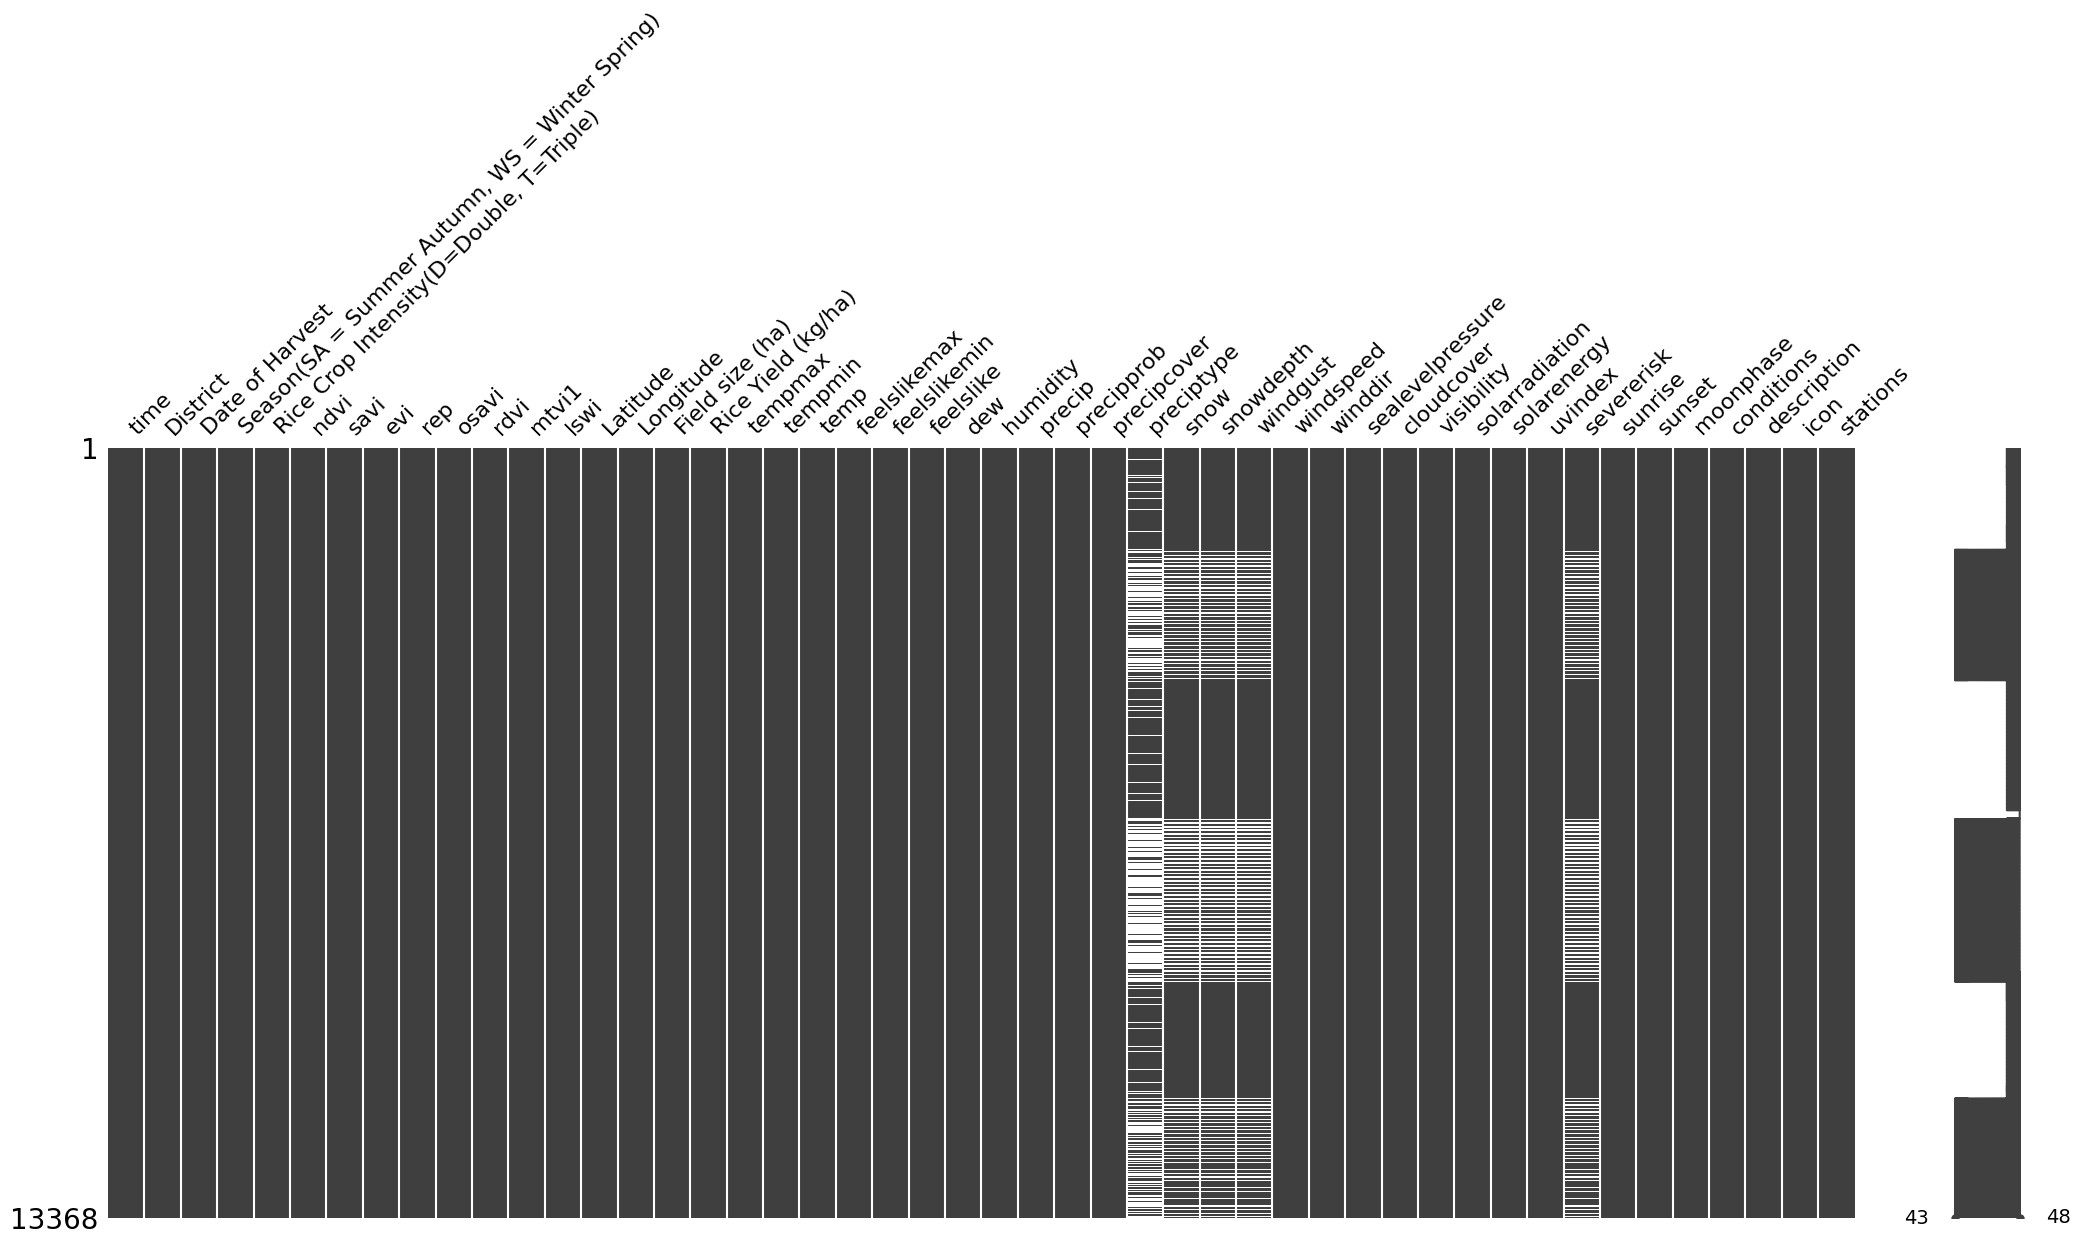

In [6]:
msno.matrix(xdf.to_dataframe())

<AxesSubplot: >

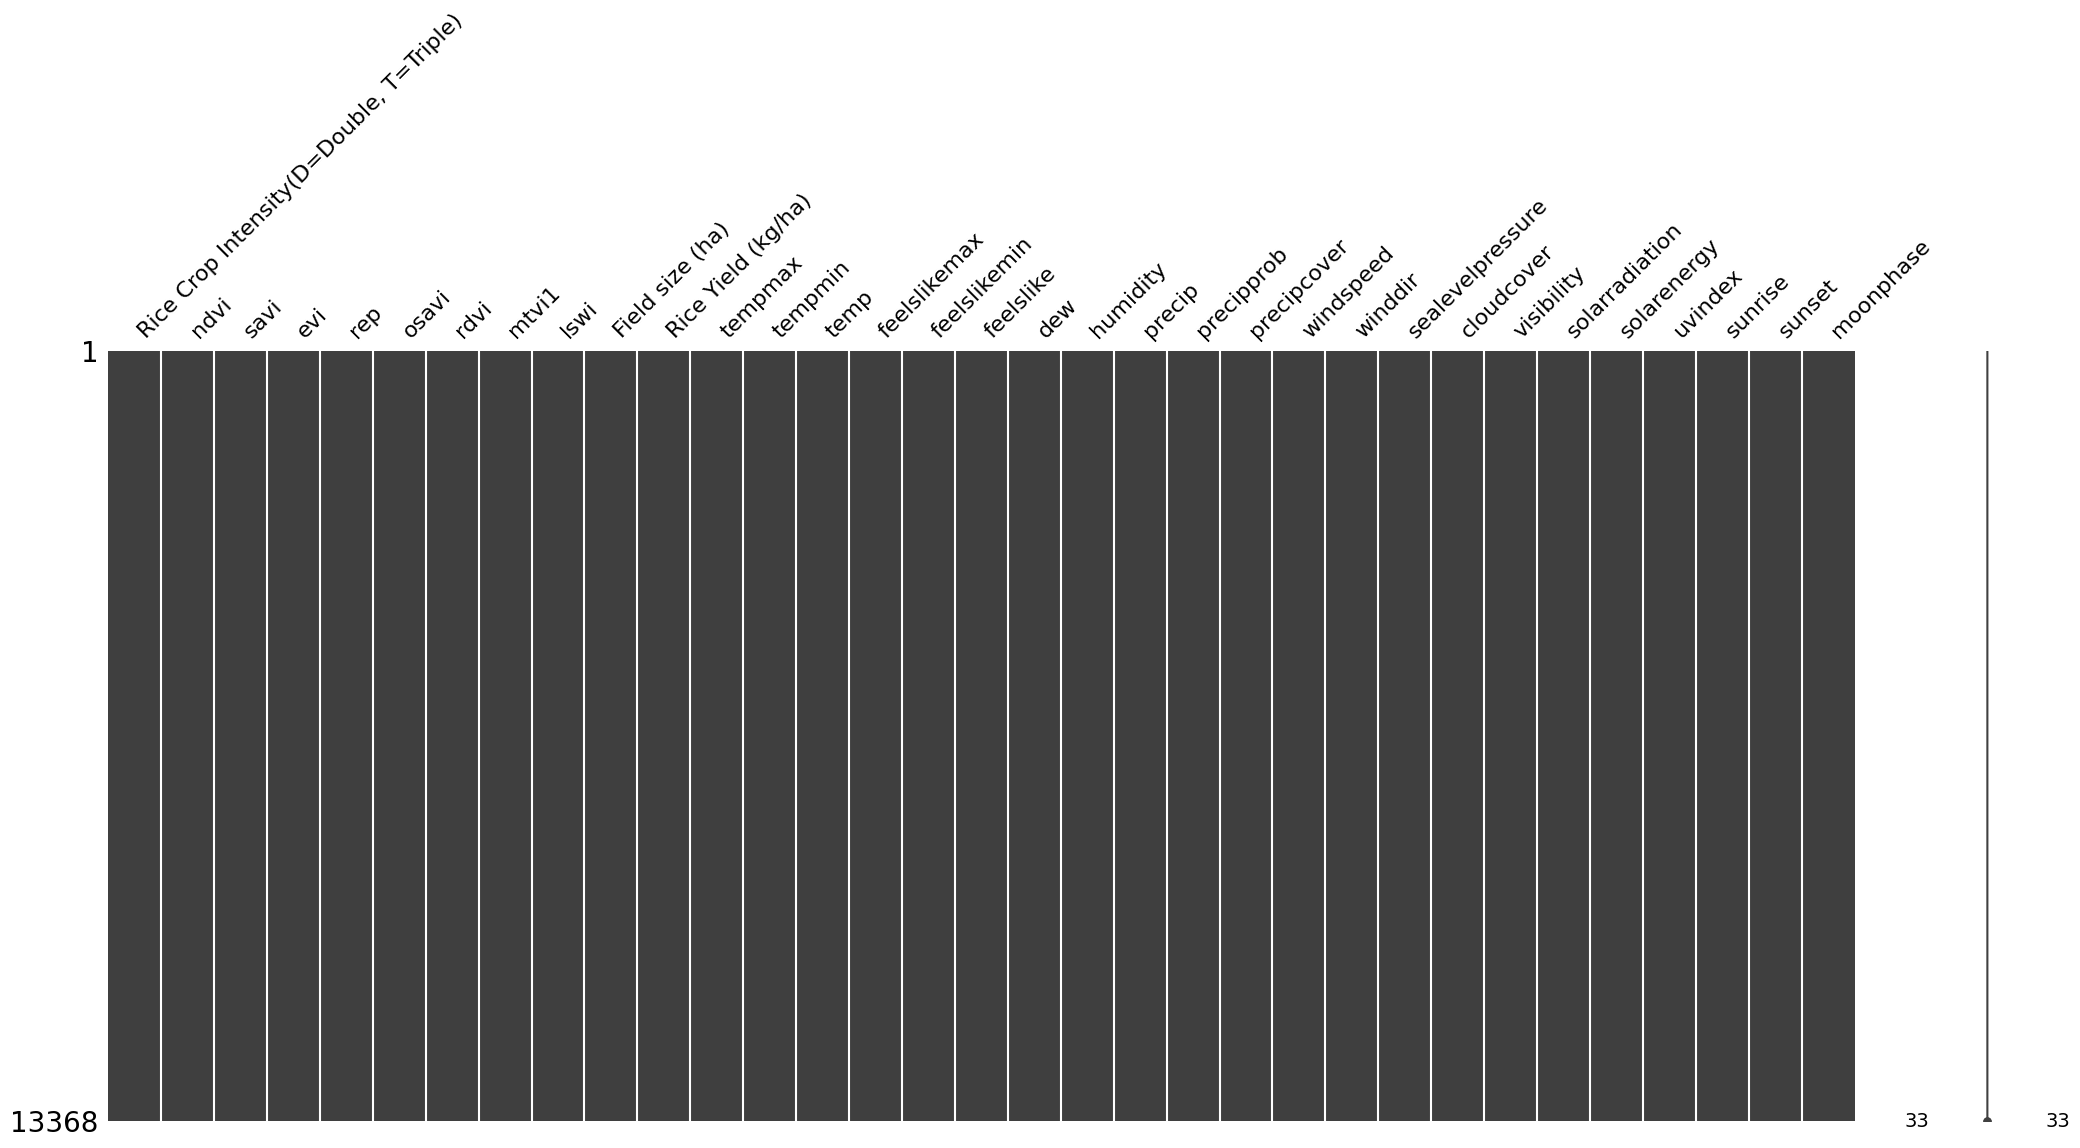

In [7]:
xdf = xdf.drop(['stations', 'icon', 'description', 'conditions', 'severerisk', 'windgust', 'snowdepth', 'snow', 'preciptype', 'time', 'District', 'Season(SA = Summer Autumn, WS = Winter Spring)', 'Date of Harvest', 'Latitude', 'Longitude'])
msno.matrix(xdf.to_dataframe())

# Feature Engineering

## Categorical Data

In [8]:
xdf['Rice Crop Intensity(D=Double, T=Triple)'] = xdf['Rice Crop Intensity(D=Double, T=Triple)'].str.replace("D", "2").str.replace("T", "3").astype(np.int8)
np.unique(xdf['Rice Crop Intensity(D=Double, T=Triple)'], return_counts=True)

(array([2, 3], dtype=int8), array([ 2088, 11280]))

## Numerical data

In [9]:
xdf['sunrise'] = xdf['sunrise'].astype(np.datetime64)
xdf['sunset'] = xdf['sunset'].astype(np.datetime64)

xdf['solarexposure'] = (xdf['sunset'] - xdf['sunrise']).dt.seconds

xdf = xdf.drop(['sunrise', 'sunset']) 

xdf.solarexposure

<xarray.DataArray 'solarexposure' (ts_id: 557, state_dev: 24)>
array([[45682, 45756, 45812, ..., 43804, 43627, 43450],
       [45682, 45756, 45812, ..., 43804, 43627, 43450],
       [45682, 45756, 45812, ..., 43804, 43627, 43450],
       ...,
       [44306, 44139, 43969, ..., 41494, 41525, 41574],
       [44630, 44469, 44306, ..., 41490, 41482, 41494],
       [44306, 44139, 43969, ..., 41494, 41525, 41574]])
Coordinates:
  * state_dev  (state_dev) int32 23 22 21 20 19 18 17 16 15 ... 7 6 5 4 3 2 1 0
Dimensions without coordinates: ts_id

# Data Preparation

In [10]:
# Transform xarray dataset to pandas dataframe
df = xdf.to_dataframe()
df.reset_index(inplace=True)
df.set_index(['ts_id', 'Rice Crop Intensity(D=Double, T=Triple)', 'Field size (ha)', TARGET], inplace=True)
# Pivot on my dataframe to have all my days on the same row
df['state_dev'] = df['state_dev'].astype(str)
df = df.pivot(columns="state_dev")
df.reset_index(inplace=True)
df.set_index('ts_id', inplace=True)
index = df.columns.to_flat_index() 
df.columns = df.columns.map('_'.join).str.strip('_')
df

,"Rice Crop Intensity(D=Double, T=Triple)",Field size (ha),Rice Yield (kg/ha),ndvi_0,ndvi_1,ndvi_10,ndvi_11,ndvi_12,ndvi_13,ndvi_14,...,solarexposure_21,solarexposure_22,solarexposure_23,solarexposure_3,solarexposure_4,solarexposure_5,solarexposure_6,solarexposure_7,solarexposure_8,solarexposure_9
ts_id,,,,,,,,,,,,,,,,,,,,,
0,3,3.40,5500.0,0.298518,0.303382,0.382258,0.432473,0.484737,0.457726,0.445272,...,45812,45756,45682,43980,44155,44327,44496,44662,44821,44975
1,3,2.43,6000.0,0.320601,0.354856,0.510501,0.540132,0.558176,0.515149,0.499457,...,45812,45756,45682,43980,44155,44327,44496,44662,44821,44975
2,2,1.95,6400.0,0.302784,0.366220,0.441343,0.496216,0.503530,0.492972,0.497362,...,45812,45756,45682,43980,44155,44327,44496,44662,44821,44975
3,3,4.30,6000.0,0.349975,0.366209,0.366773,0.438328,0.506111,0.505829,0.490933,...,45812,45756,45682,43980,44155,44327,44496,44662,44821,44975
4,2,3.30,6400.0,0.315784,0.312731,0.449383,0.586708,0.594910,0.556279,0.487145,...,45812,45756,45682,43980,44155,44327,44496,44662,44821,44975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,3,7.80,6640.0,0.607559,0.323314,0.499843,0.532900,0.537773,0.533247,0.577491,...,43969,44139,44306,41482,41490,41518,41564,41628,41807,42040
553,3,2.00,7200.0,0.604312,0.260624,0.637760,0.590083,0.533283,0.557181,0.582885,...,43969,44139,44306,41482,41490,41518,41564,41628,41807,42040
554,3,6.20,7200.0,0.225860,0.155104,0.595694,0.548989,0.520725,0.547583,0.546937,...,43969,44139,44306,41482,41490,41518,41564,41628,41807,42040


In [11]:
# Split Features & Target
X, y = df.drop(columns=TARGET), df[[TARGET]]

## Split Data

In [12]:
# Split dataset into Train/Test subdataset equitably distributed according to TARGET
# Repeat the operation to create Train/Val/Test subdataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Scale Data

Because XGBoost is a decision tree based algorithm it not required normalization of their inputs.

In [13]:
# # Depend of the model used a data scaling is requered
# scaler = StandardScaler()
# X_train_scale = scaler.fit_transform(X_train)

# # X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
# # X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
# X_test_scale = scaler.transform(X_test)

# # Save scaler for a future use
# scaler_filename = "scaler.save"
# joblib.dump(scaler, scaler_filename) 
# # to load it
# # scaler = joblib.load(scaler_filename) 

# X_train.head()

# Machine Learning Regression

## XGBoost

### Train

In [14]:
xgbr = XGBRegressor(random_state=0, max_depth=3)

param_grid = { 
    'max_depth' : np.linspace(2, 10, 5, dtype=int),
    'n_estimators': np.linspace(100, 1000, 5, dtype=int),
    'learning_rate': np.linspace(0.01, 0.3, 5, dtype=float),
    # 'colsample_bytree': np.linspace(0.5, 1, 5, dtype=float),
    # 'subsample': np.linspace(0.6, 1, 5, dtype=float),
}

# Perform a grid search
cv_xgbr = GridSearchCV(xgbr, param_grid, n_jobs=-1, verbose=1)
cv_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


In [ ]:
cv_xgbr.best_params_

{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 550}

### Evaluate

In [ ]:
y_pred = cv_xgbr.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.0f} | MAPE: {100*mape:.1f}% | R2 score: {r2:.3f}')

RMSE: 471 | MAPE: 5.8% | R2 score: 0.634


In [ ]:
# Plot features importance
df_fi = pd.DataFrame(columns=['Feature', 'Importance'])
df_fi['Feature'] = X.columns
df_fi['Importance'] = cv_xgbr.best_estimator_.feature_importances_
df_fi.sort_values('Importance', inplace=True, ascending=False)

fig = px.bar(df_fi.head(10), x='Feature', y='Importance', title="Feature importance")
fig.show()

# Save the model

In [ ]:
model_filename = "../model/adaptative/cv_xgboost.save"
joblib.dump(cv_xgbr, model_filename)

['../model/adaptative/cv_xgboost.save']

# Train Final Model

In [ ]:
param = copy.deepcopy(cv_xgbr.best_params_)
param["random_state"] = 0

xgbr = XGBRegressor(**param)

xgbr.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=550, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [ ]:
model_filename = "../model/adaptative/xgboost.save"
joblib.dump(xgbr, model_filename)

['../model/adaptative/xgboost.save']

# Test file

In [ ]:
xdf = xr.open_dataset('../../data/processed/adaptative_factor_1/test_filter_vi_fill_smooth.nc')
xdf = xdf.set_coords(['time', 'District'])
xdf

<xarray.Dataset>
Dimensions:                                         (ts_id: 100, state_dev: 24)
Coordinates:
    time                                            (ts_id, state_dev) object ...
    District                                        (ts_id, state_dev) object ...
  * state_dev                                       (state_dev) int32 23 ... 0
Dimensions without coordinates: ts_id
Data variables: (12/16)
    Date of Harvest                                 (ts_id, state_dev) object ...
    Season(SA = Summer Autumn, WS = Winter Spring)  (ts_id, state_dev) object ...
    Rice Crop Intensity(D=Double, T=Triple)         (ts_id, state_dev) object ...
    ndvi                                            (ts_id, state_dev) float32 ...
    savi                                            (ts_id, state_dev) float32 ...
    evi                                             (ts_id, state_dev) float32 ...
    ...                                              ...
    lswi                                            (ts_id, state_dev) float32 ...
    ID No                                           (ts_id, state_dev) float64 ...
    Latitude                                        (ts_id, state_dev) float64 ...
    Longitude                                       (ts_id, state_dev) float64 ...
    Field size (ha)                                 (ts_id, state_dev) float64 ...
    Predicted Rice Yield (kg/ha)                    (ts_id, state_dev) float64 ...

In [ ]:
weather = []
for path in glob.glob('../../data/raw/weather/*.csv'):
    weather.append(pd.read_csv(path))

df_weather = pd.concat(weather, axis='index')
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather = df_weather.rename(columns={'name': 'District', 'datetime': 'time'})
df_weather.set_index(['time', 'District'], inplace=True)
xdf_weather = df_weather.to_xarray().set_coords(['District', 'time'])
xdf_weather['District'] = xdf_weather['District'].str.replace(' ', '_')
xdf_weather['time'] = xdf_weather['time'].dt.strftime('%Y-%m-%d')
xdf_weather

del df_weather, weather, path

In [ ]:
xdf = xr.merge([xdf, xdf_weather.sel(District=xdf.District, time=xdf.time)])
xdf

del xdf_weather

# Missing Data

<AxesSubplot: >

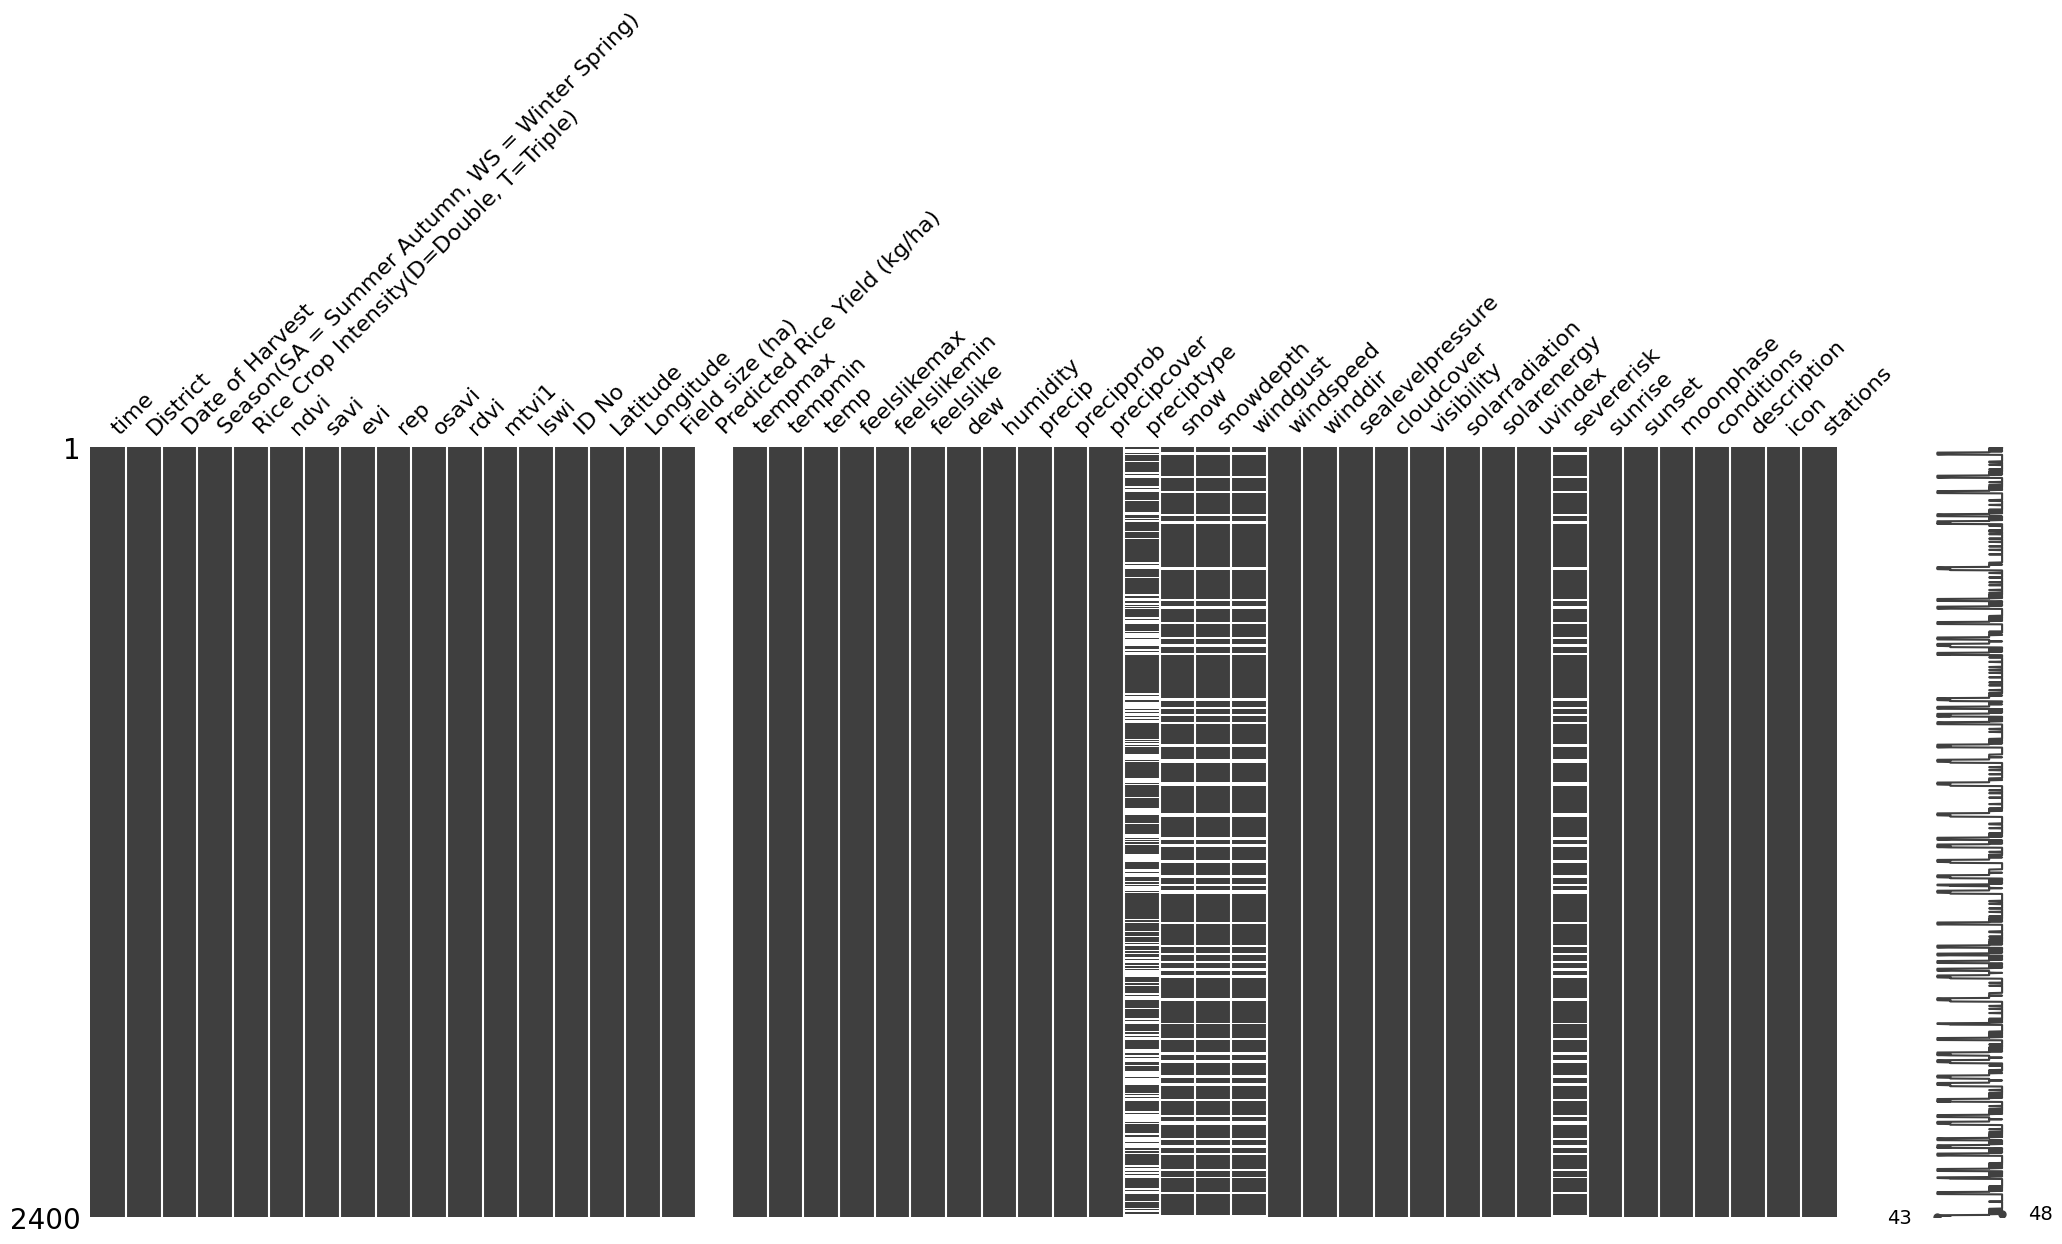

In [ ]:
msno.matrix(xdf.to_dataframe())

<AxesSubplot: >

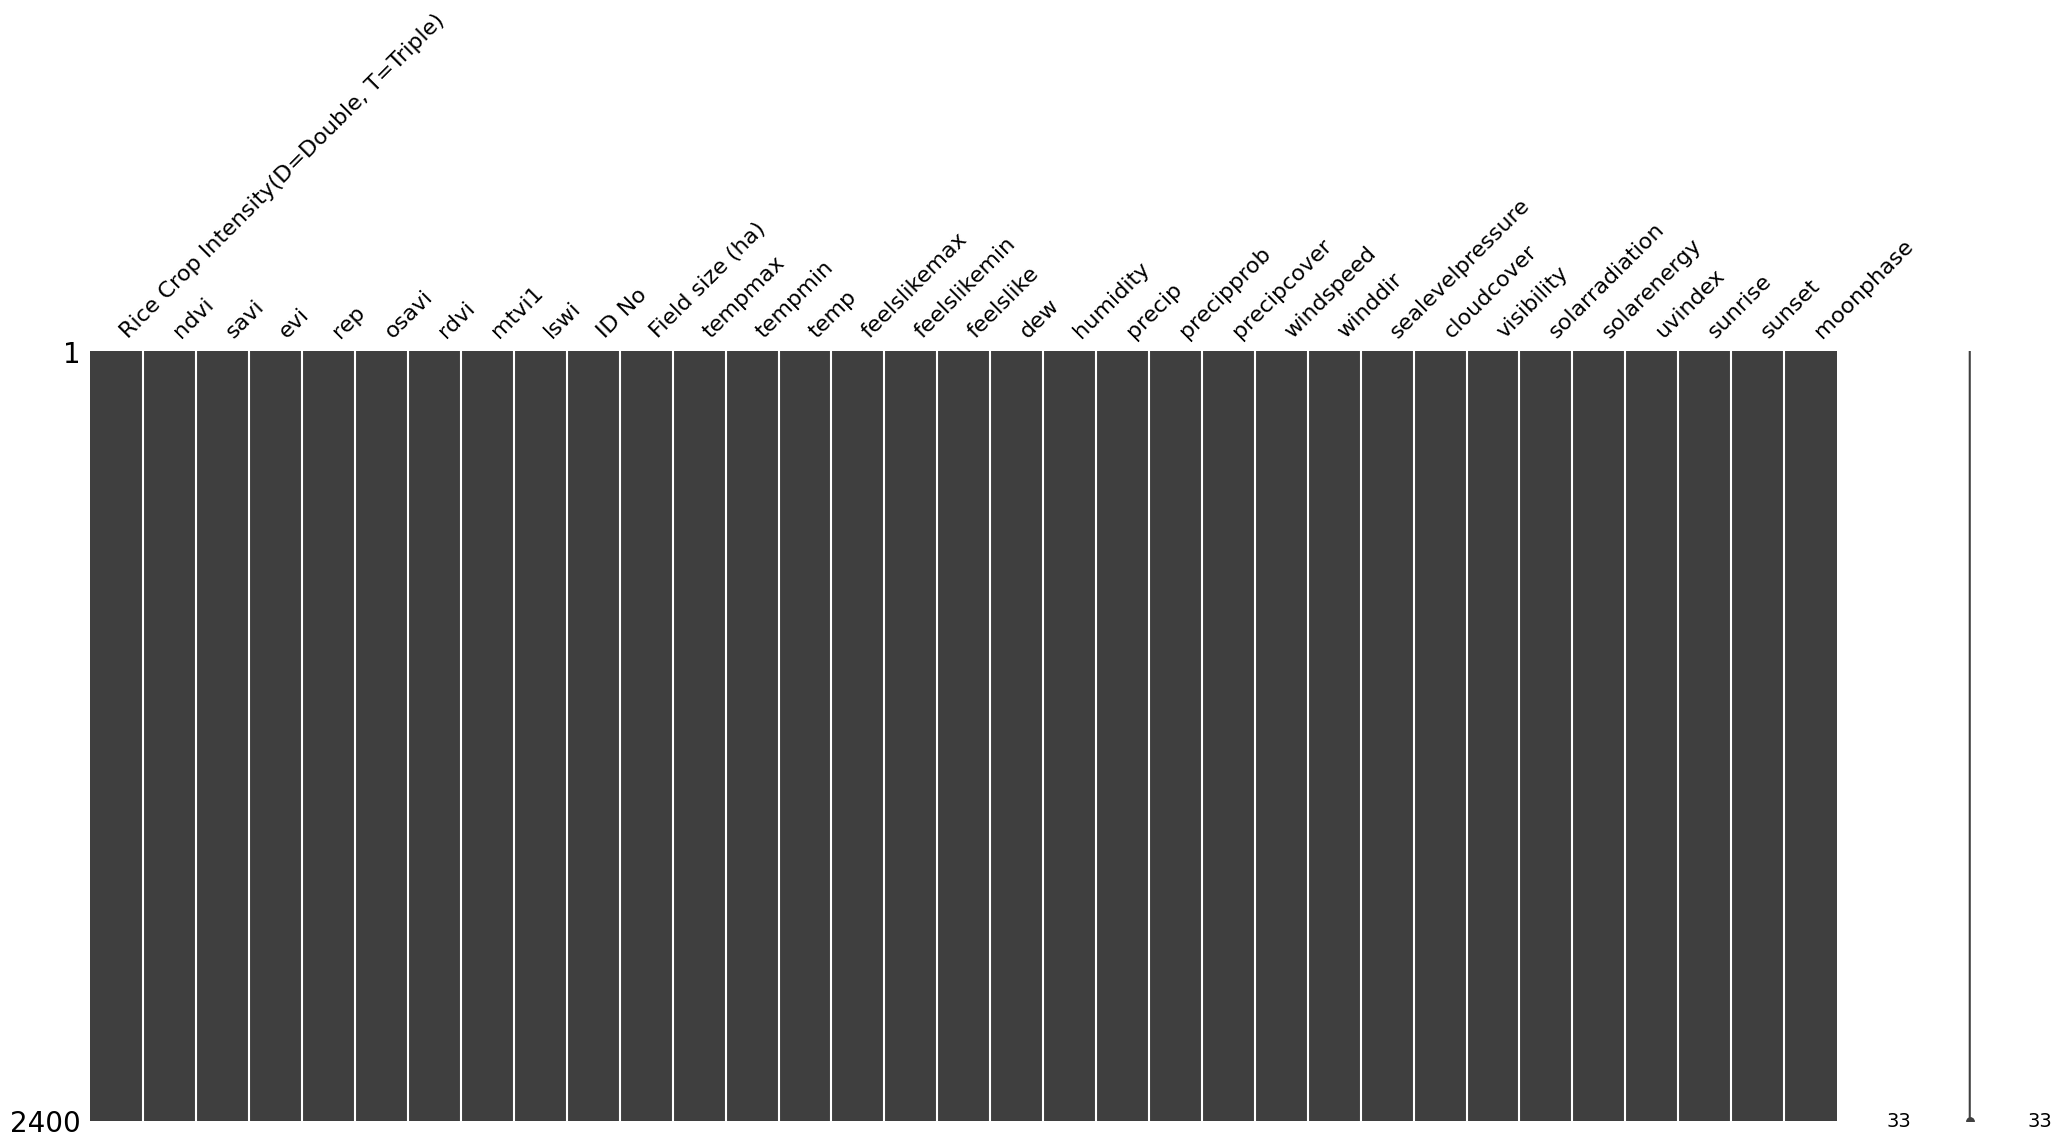

In [ ]:
xdf = xdf.drop(['stations', 'icon', 'description', 'conditions', 'severerisk', 'windgust', 'snowdepth', 'snow', 'preciptype', 'time', 'Predicted Rice Yield (kg/ha)', 'District', 'Latitude', 'Longitude', 'Season(SA = Summer Autumn, WS = Winter Spring)', 'Date of Harvest',])
msno.matrix(xdf.to_dataframe())

# Feature Engineering

## Categorical Data

In [ ]:
xdf['Rice Crop Intensity(D=Double, T=Triple)'] = xdf['Rice Crop Intensity(D=Double, T=Triple)'].str.replace("D", "2").str.replace("T", "3").astype(np.int8)
np.unique(xdf['Rice Crop Intensity(D=Double, T=Triple)'], return_counts=True)

(array([2, 3], dtype=int8), array([ 552, 1848]))

## Numerical data

In [ ]:
xdf['sunrise'] = xdf['sunrise'].astype(np.datetime64)
xdf['sunset'] = xdf['sunset'].astype(np.datetime64)

xdf['solarexposure'] = (xdf['sunset'] - xdf['sunrise']).dt.seconds

xdf = xdf.drop(['sunrise', 'sunset']) 

xdf.solarexposure

<xarray.DataArray 'solarexposure' (ts_id: 100, state_dev: 24)>
array([[44327, 44155, 43980, ..., 41429, 41460, 41511],
       [45541, 45609, 45661, ..., 43790, 43624, 43459],
       [45682, 45756, 45812, ..., 43804, 43627, 43450],
       ...,
       [45458, 45541, 45609, ..., 43954, 43790, 43624],
       [45541, 45609, 45661, ..., 43790, 43624, 43459],
       [44327, 44155, 43980, ..., 41429, 41460, 41511]])
Coordinates:
  * state_dev  (state_dev) int32 23 22 21 20 19 18 17 16 15 ... 7 6 5 4 3 2 1 0
Dimensions without coordinates: ts_id

# Data Preparation

In [ ]:
# Transform xarray dataset to pandas dataframe
df = xdf.to_dataframe()
df.reset_index(inplace=True)
df['state_dev'] = df['state_dev'].astype(str)
df.set_index(['ts_id', 'ID No', 'Rice Crop Intensity(D=Double, T=Triple)', 'Field size (ha)'], inplace=True)
# Pivot on my dataframe to have all my days on the same row
df = df.pivot(columns="state_dev")
df.columns = df.columns.map('_'.join).str.strip('_')
df.reset_index(inplace=True)
df = df.set_index(['ts_id', 'ID No'])
df

,,"Rice Crop Intensity(D=Double, T=Triple)",Field size (ha),ndvi_0,ndvi_1,ndvi_10,ndvi_11,ndvi_12,ndvi_13,ndvi_14,ndvi_15,...,solarexposure_21,solarexposure_22,solarexposure_23,solarexposure_3,solarexposure_4,solarexposure_5,solarexposure_6,solarexposure_7,solarexposure_8,solarexposure_9
ts_id,ID No,,,,,,,,,,,,,,,,,,,,,
0,1.0,3,1.40,0.522180,0.273375,0.470109,0.512067,0.518279,0.522272,0.538642,0.533651,...,43980,44155,44327,41417,41425,41453,41501,41568,41752,41992
1,2.0,3,1.32,0.300203,0.272888,0.445562,0.507116,0.504647,0.534541,0.504247,0.546717,...,45661,45609,45541,43954,44116,44277,44434,44588,44738,44881
2,3.0,2,1.40,0.316360,0.451463,0.385751,0.398639,0.445115,0.489429,0.467523,0.546230,...,45812,45756,45682,43980,44155,44327,44496,44662,44821,44975
3,4.0,2,1.80,0.166927,0.108061,0.656044,0.575287,0.587128,0.591716,0.586263,0.523867,...,43980,44155,44327,41417,41425,41453,41501,41568,41752,41992
4,5.0,3,2.20,0.152196,0.099333,0.489553,0.506878,0.476354,0.458703,0.466293,0.481162,...,45692,45621,45535,44139,44306,44469,44630,44785,44934,45210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96.0,2,1.21,0.300689,0.127546,0.485366,0.480411,0.483199,0.494415,0.513074,0.515870,...,45541,45458,45363,44277,44434,44588,44738,44881,45146,45265
96,97.0,3,2.00,0.532129,0.289509,0.554117,0.520234,0.499872,0.507025,0.506170,0.491156,...,43980,44155,44327,41417,41425,41453,41501,41568,41752,41992
97,98.0,3,5.50,0.287286,0.235191,0.524934,0.545597,0.564622,0.560302,0.568345,0.554321,...,45609,45541,45458,44116,44277,44434,44588,44738,44881,45146


# Load the model

In [ ]:
model_filename = "../model/adaptative/xgboost.save"
model = joblib.load(model_filename)

In [ ]:
y_pred = model.predict(df)

In [ ]:
s_pred = pd.Series(y_pred, index=df.index, name='Predicted Rice Yield (kg/ha)')

# Load Submissions file

In [ ]:
df_sub = pd.read_csv("../../data/raw/test.csv")
df_sub.drop(columns='Predicted Rice Yield (kg/ha)', inplace=True)
df_sub.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20


In [ ]:
df_sub = pd.merge(df_sub, s_pred, on="ID No")
df_sub.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,7344.078613
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,5946.680664
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,5941.944336
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,7281.490234
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,5691.092285


In [ ]:
sub_filename = '../model/adaptative/submission.csv'
df_sub.to_csv(sub_filename, index=False, header=True)